# Kalman Filters

Kalman Filter is a powerfull tool to reconcile the measure of a sensor with the estimation of the value.

Sensors are noise therefore if we can add information to the measure is posible to reduce the noise and get better accurasy, i kind of information we can add is the estimation base on time, by modeling our probleme to take the last measure value and estimate the next, it is posible to use Kalman Filter to add the information of the estimation model with the measure value.

For mor information:
https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python

## GPS Kalman Filter

This notebook implement Kalman filter to the GPS position of a monolic

This is the easies case, were the model of estimation is the measure do not change.

## Adquiring data

In [1]:
from __future__ import division

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

%run -i ../../code/multirover4.py
%run -i utils.py
%run -i utils_enu.py


In [2]:
navfile = "data/bara0100.17n" #"data/dyh20970.15n" #"data/tgdr0100.17n"#
obsfile = "data/bara0100.17o" #"data/dyh20970.15o" #"data/tgdr0100.17o" #
#data, bcestore, rec_pos = rinex_to_dataframe(obsfile, navfile)
data, bcestore, rec_pos = rinex_to_dataframe_ionosfe(obsfile, navfile)

WARNING! observation `C2` no present in file data/bara0100.17o


### Describing the process of position calculation

The calculation is done with only one frecuency

In [3]:
data.iloc[0]

gps_week                                                 1931
gps_sow                                              1.73e+05
gps_time_corr                                       -0.000278
alphas            [7.4506e-09, -1.4901e-08, -5.9605e-08, 1...
betas                [90112.0, -65536.0, -131070.0, 458750.0]
gamma                                                    1.65
prns              [GPS3, GPS8, GPS9, GPS14, GPS16, GPS21, ...
prns_pos          [[-11930659.1143, -23426922.8533, -38328...
prns_clockbias    [-0.000105455135702, -4.54596737538e-05,...
prns_relcorr      [-5.40677641322e-10, -1.94282336373e-09,...
prns_elev         [25.0202998777, 32.6297670477, 7.1846404...
prns_az           [243.706567225, 195.212907735, 322.47921...
Iono              [11.6470588318, 9.75199656654, 5.8258480...
P1                [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...
P2                [23266960.98, 22526837.387, 24890618.332...
L1                [122268660.439, 118379246.956, 130801072...
L2      

In [4]:
o = data.iloc[12]
obser = o.C1
idxs = np.arange(len(obser))
p1,pos = np.array(obser)[idxs], np.array(o.prns_pos)[idxs]
clocks = np.array(o.prns_clockbias)[idxs]
p1,pos = obser[idxs], o.prns_pos[idxs]
clocks = o.prns_clockbias[idxs]
raim_computed_pos   = compute_raim_position(o.gps_week, o.gps_sow, o.prns, o.prns_pos, obser, bcestore)
ls_computed_pos,A,b,_ = compute_least_squares_position(pos, clocks, p1)

In [5]:
ls_computed_pos

array([  1.96336103e+06,  -5.73396916e+06,   1.98035586e+06,
         3.92344233e+01])

In [6]:
np.linalg.pinv(A.T.dot(A))

array([[ 0.42041883, -0.36898863,  0.11402342,  0.24599042],
       [-0.36898863,  0.99088538, -0.2362933 , -0.50361282],
       [ 0.11402342, -0.2362933 ,  0.30000655,  0.14770493],
       [ 0.24599042, -0.50361282,  0.14770493,  0.35341408]])

### Getting all points and plotting them in ENU

In [7]:
points = []
covars = []
for i, o in data.iterrows():
    if i % 100 == 0:
        obser = o.C1
        idxs = np.arange(len(obser))
        p1,pos = np.array(obser)[idxs], np.array(o.prns_pos)[idxs]
        clocks = np.array(o.prns_clockbias)[idxs]
        p1,pos = obser[idxs], o.prns_pos[idxs]
        clocks = o.prns_clockbias[idxs]
        raim_computed_pos   = compute_raim_position(o.gps_week, o.gps_sow, o.prns, o.prns_pos, obser, bcestore)
        ls_computed_pos,A,b,_ = compute_least_squares_position(pos, clocks, p1)

        if np.linalg.norm(ls_computed_pos[:3] - rec_pos) > 1000:
            continue

        sigma = 1
        dop = sigma**2 * np.linalg.pinv(A.T.dot(A))
        points.append(ls_computed_pos)
        covars.append(dop)

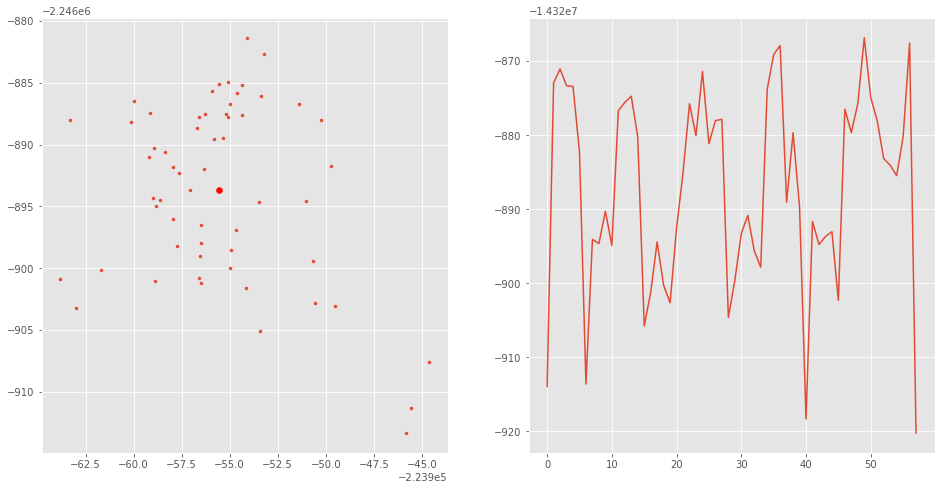

In [8]:
_points = np.asarray([p for p in points])

enu_all = np.asarray(ecef2enu(_points[:,0], _points[:,1], _points[:,2], *rec_pos))
enu_mean = enu_all.mean(axis=1)

plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)
plt.scatter(enu_all[0], enu_all[1], marker='.')
plt.scatter(enu_mean[0], enu_mean[1], c='r')

plt.subplot(1, 2, 2)
plt.plot(enu_all[2])

In [9]:
print "Total error =", np.mean(np.linalg.norm(_points[:,:3] - rec_pos, axis=1))

Total error = 50.8987174362


## Using Kalman

### First aproach

We only use (x,y,z,t) as model input

We use the matrix of delution as the error of the model

In [10]:
from numpy import dot
from scipy.linalg import inv

x = points[0]
P = covars[0]
Q = np.cov(np.asarray(points).T)
Q = Q / np.linalg.norm(Q)

F = np.eye(4)
H = np.eye(4)

xs, cov = [], []
for z, R in zip(points[1:], covars[1:]):
    # predict
    x = dot(F, x)
    P = dot(F, P).dot(F.T) + Q
    
    #update
    S = dot(H, P).dot(H.T) + 16*R
    K = dot(P, H.T).dot(inv(S))
    y = z - dot(H, x)
    x += dot(K, y)
    P = P - dot(K, H).dot(P)
    
    xs.append(x)
    cov.append(P)

In [11]:
error_ls = []
for p in points:
    e = np.linalg.norm(p[:3] - rec_pos)
    error_ls.append(e)

error_kl = []
for x in xs:
    e = np.linalg.norm(x[:3] - rec_pos)
    error_kl.append(e)

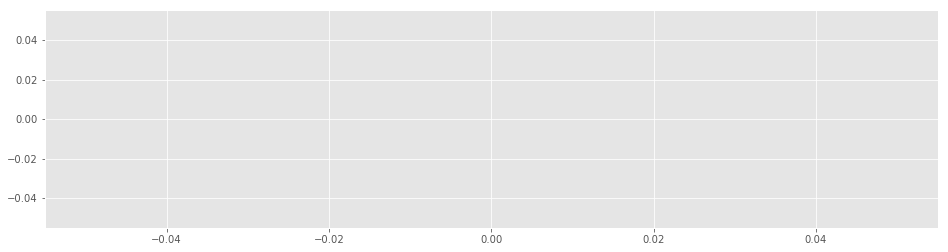

In [12]:
plt.figure(figsize=(16,4))
plt.plot(error_ls[800:1200], marker='.', color='green', linewidth=0)
plt.plot(np.roll(error_kl[800:1200],1), marker='.', color='blue', linewidth=0)

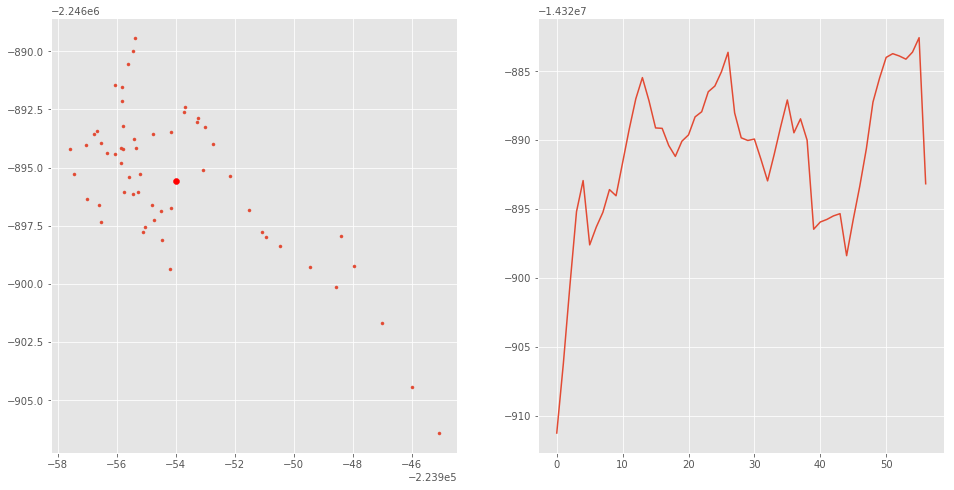

In [13]:
_points = np.asarray([p for p in xs])

enu_all = np.asarray(ecef2enu(_points[:,0], _points[:,1], _points[:,2], *rec_pos))
enu_mean = enu_all.mean(axis=1)

plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)
plt.scatter(enu_all[0], enu_all[1], marker='.')
plt.scatter(enu_mean[0], enu_mean[1], c='r')

plt.subplot(1, 2, 2)
plt.plot(enu_all[2])

In [14]:
print "Total error =", np.mean(np.linalg.norm(_points[:,:3] - rec_pos, axis=1))

Total error = 47.3203332883


### Second aproach

We add the velocity vector to the model (x, y, z, t, $v_x$, $v_y$, $v_z$)

In [15]:
from numpy import dot
from scipy.linalg import pinv as inv

v = np.array([0, 0, 0])
_add_zeros = lambda(P): np.hstack([np.vstack([P, np.zeros((3,4))]), np.zeros((7,3))])

x = np.append(points[0], v)
P = _add_zeros(covars[0])
Q = np.cov(np.asarray(points).T)
Q = Q / np.linalg.norm(Q)
Q = _add_zeros(Q)

H = np.eye(7,7)
F = np.array([[ 1.,  0.,  0.,  0.,  1.,  0.,  0.],
              [ 0.,  1.,  0.,  0.,  0.,  1.,  0.],
              [ 0.,  0.,  1.,  0.,  0.,  0.,  1.],
              [ 0.,  0.,  0.,  1.,  0.,  0.,  0.],
              [ 0.,  0.,  0.,  0.,  1.,  0.,  0.],
              [ 0.,  0.,  0.,  0.,  0.,  1.,  0.],
              [ 0.,  0.,  0.,  0.,  0.,  0.,  1.]])

xs, cov = [], []
for z, R in zip(points[1:], covars[1:]):
    z = np.append(z, v)
    R = _add_zeros(R)
    
    # predict
    x = dot(F, x)
    P = dot(F, P).dot(F.T) + Q
    
    #update
    S = dot(H, P).dot(H.T) + 9*R
    K = dot(P, H.T).dot(inv(S))
    y = z - dot(H, x)
    x += dot(K, y)
    P = P - dot(K, H).dot(P)
    
    xs.append(x)
    cov.append(P)

In [16]:
error_ls = []
for p in points:
    e = np.linalg.norm(p[:3] - rec_pos)
    error_ls.append(e)

error_kl = []
for x in xs:
    e = np.linalg.norm(x[:3] - rec_pos)
    error_kl.append(e)

In [17]:
plt.figure(figsize=(16,4))
plt.plot(error_ls[:], marker='.', color='green', linewidth=0)
plt.plot(np.roll(error_kl[:],1), marker='.', color='blue', linewidth=0)

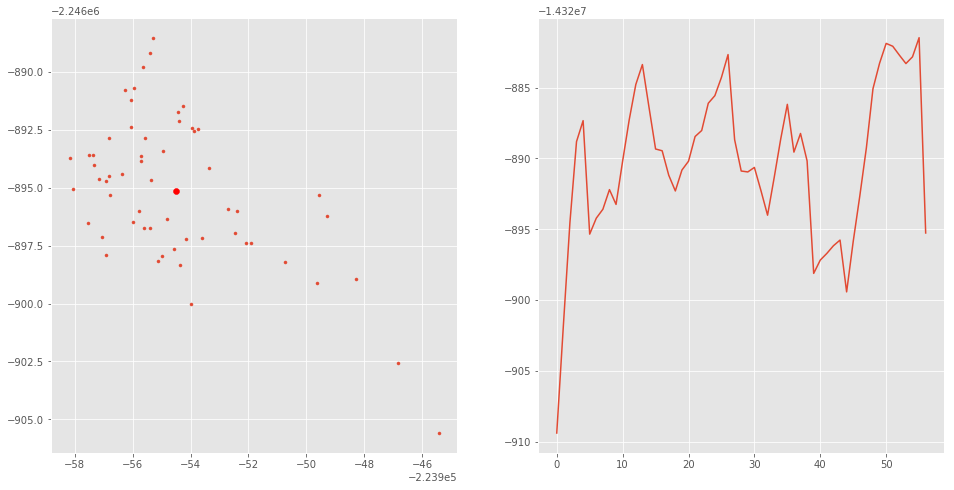

In [18]:
_points = np.asarray([p for p in xs])

enu_all = np.asarray(ecef2enu(_points[:,0], _points[:,1], _points[:,2], *rec_pos))
enu_mean = enu_all.mean(axis=1)

plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)
plt.scatter(enu_all[0], enu_all[1], marker='.')
plt.scatter(enu_mean[0], enu_mean[1], c='r')

plt.subplot(1, 2, 2)
plt.plot(enu_all[2])

In [19]:
print "Total error =", np.mean(np.linalg.norm(_points[:,:3] - rec_pos, axis=1))

Total error = 47.6090960324


### Third aproach

Remodel of the error step, we only add the error of the clock

In [20]:
1/(gpstk.C_MPS/(gpstk.L1_FREQ_GPS))/gpstk.GAMMA_GPS

3.1907788314993866

In [29]:
from numpy import dot
from scipy.linalg import pinv as inv

v = np.array([0, 0, 0])
_add_zeros = lambda(P): np.hstack([np.vstack([P, np.zeros((3,4))]), np.zeros((7,3))])

x = np.append(points[0], v)
P = _add_zeros(covars[0])
_Q = np.cov(np.asarray(points).T)
_Q = _Q / np.linalg.norm(_Q)
Q = np.zeros((7,7))
Q[3,3] = 900 #1/(gpstk.C_MPS/(gpstk.L1_FREQ_GPS))/gpstk.GAMMA_GPS #3.053938    # np.std(points[3]) / 1000    # It is magic, not science

#Q = np.zeros((4,4))
#Q[3, [0,1,2,3]] = _Q[3, [0,1,2,3]]
#Q[[0,1,2,3], 3] = _Q[[0,1,2,3], 3]
#Q = _add_zeros(Q)

H = np.eye(7,7)
F = np.array([[ 1.,  0.,  0.,  0.,  1.,  0.,  0.],
              [ 0.,  1.,  0.,  0.,  0.,  1.,  0.],
              [ 0.,  0.,  1.,  0.,  0.,  0.,  1.],
              [ 0.,  0.,  0.,  0.,  0.,  0.,  0.],
              [ 0.,  0.,  0.,  0.,  1.,  0.,  0.],
              [ 0.,  0.,  0.,  0.,  0.,  1.,  0.],
              [ 0.,  0.,  0.,  0.,  0.,  0.,  1.]])

xs, cov = [], []
for z, R in zip(points[1:], covars[1:]):
    z = np.append(z, v)
    R = _add_zeros(R)
    
    # predict
    x = dot(F, x)
    P = dot(F, P).dot(F.T) + Q
    
    #update
    S = dot(H, P).dot(H.T) + 9*R
    K = dot(P, H.T).dot(inv(S))
    y = z - dot(H, x)
    x += dot(K, y)
    P = P - dot(K, H).dot(P)
    
    xs.append(x)
    cov.append(P)

In [30]:
## 
error_ls = []
for p in points:
    e = np.linalg.norm(p[:3] - rec_pos)
    error_ls.append(e)

error_kl = []
for x in xs:
    e = np.linalg.norm(x[:3] - rec_pos)
    error_kl.append(e)

(0, 60)

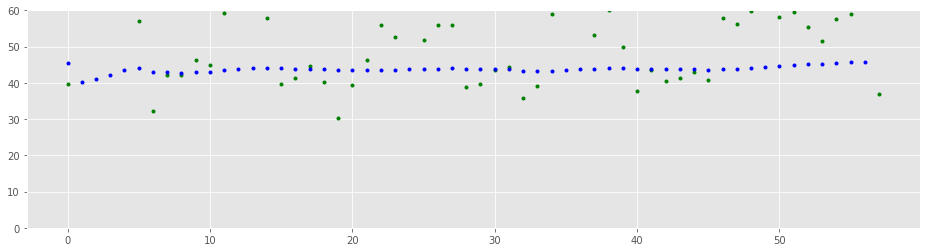

In [31]:
##
plt.figure(figsize=(16,4))
plt.plot(error_ls[:], marker='.', color='green', linewidth=0)
plt.plot(np.roll(error_kl[:],1), marker='.', color='blue', linewidth=0)
plt.ylim((0,60))

In [24]:

_points = np.asarray([p for p in xs])

"""
enu_all = np.asarray(ecef2enu(_points[:,0], _points[:,1], _points[:,2], *rec_pos))
enu_mean = enu_all.mean(axis=1)

plt.figure(figsize=(16,8))

plt.subplot(1, 2, 1)
plt.scatter(enu_all[0], enu_all[1], marker='.')
plt.scatter(enu_mean[0], enu_mean[1], marker='.', c='r')

plt.subplot(1, 2, 2)
plt.plot(enu_all[2])
"""

"\nenu_all = np.asarray(ecef2enu(_points[:,0], _points[:,1], _points[:,2], *rec_pos))\nenu_mean = enu_all.mean(axis=1)\n\nplt.figure(figsize=(16,8))\n\nplt.subplot(1, 2, 1)\nplt.scatter(enu_all[0], enu_all[1], marker='.')\nplt.scatter(enu_mean[0], enu_mean[1], marker='.', c='r')\n\nplt.subplot(1, 2, 2)\nplt.plot(enu_all[2])\n"

In [25]:
print "Total error =", np.mean(np.linalg.norm(_points[:,:3] - rec_pos, axis=1))

Total error = 44.6516898822
